<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/sfere_sensitivity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import and set directory

In [ ]:
import os
import time
import torch
import tempfile
import numpy as np
import nibabel as nib
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_3d

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

directory_path = '/content/drive/MyDrive/sfere_sensitivity'
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Function definition

In [ ]:
def create_image_3d(n_train, n_test, noise, r_min, r_max):

  for i in range(n_train + n_test):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"image{i}.nii"))
    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"label{i}.nii"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.nii")))
  labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [ ]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [ ]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds):
  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=True, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True

  epoch_loss_values = []
  metric_values = []
  metric_values_train = []
  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]

        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device),val_data["label"].to(device))

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output = post_trans(val_output[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))

    ax1.set_title("Image slice")
    ax1.imshow(val_ds[i]["image"][0, :, :, 64].detach().cpu(), cmap="gray")

    ax2.set_title("Label slice")
    ax2.imshow(val_ds[i]["label"][0, :, :, 64].detach().cpu())

    ax3.set_title("Output slice")
    ax3.imshow(val_output[0, :, :, 64].detach().cpu())

    plt.show()

    fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"},figsize = (12,6))

    z, x, y = val_ds[i]["label"][0].astype(np.uint8).nonzero()
    ax[0].scatter(x, y, z)
    ax[0].set_xlim([0,128])
    ax[0].set_ylim([0,128])
    ax[0].set_title("Label")

    z, x, y = val_output[0].astype(np.uint8).nonzero()
    ax[1].scatter(x, y, z)
    ax[1].set_xlim([0,128])
    ax[1].set_ylim([0,128])
    ax[1].set_title("Output")

    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [ ]:
def plot_train_dim(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric')
  plt.plot(n_train_vec, metric_test, label = 'Test metric')
  plt.xscale('log', base = 2)
  plt.xlabel("Train dimention")
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss')
  plt.xscale('log', base = 2)
  plt.xlabel("Train dimention")
  plt.title(f"noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

In [ ]:
def plot_noise(noise_vec, metric_train, metric_test, loss, r_min, r_max, max_epochs):
  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(noise_vec, metric_train, label = 'Train metric')
  plt.plot(noise_vec, metric_test, label = 'Test metric')
  plt.xlabel("Noise")
  plt.title(f"epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(noise_vec, loss, label = 'Train loss')
  plt.xlabel("Noise")
  plt.title(f"epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

In [ ]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)
  print()

# Execute training
Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)

## Dimention train samples

In [ ]:
n_train_vec  = [8, 16, 32, 64]
n_test = 20

noise = 1
r_min = 5
r_max = 10

max_epochs = 25

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_3d(n_train, n_test, noise, r_min, r_max)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

plot_train_dim(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)

## Noise


Noise = 0

----------
epoch 1/25
Loss: 0.8444 
Train dice: 0.5450
Test dice: 0.7620
Time: 19.2141
----------
epoch 2/25
Loss: 0.7565 
Train dice: 0.7703
Test dice: 0.8291
Time: 17.2774
----------
epoch 3/25
Loss: 0.6362 
Train dice: 0.8616
Test dice: 0.9002
Time: 17.3881
----------
epoch 4/25
Loss: 0.4617 
Train dice: 0.9146
Test dice: 0.8977
Time: 18.2116
----------
epoch 5/25
Loss: 0.2835 
Train dice: 0.9384
Test dice: 0.9659
Time: 17.0210
----------
epoch 6/25
Loss: 0.1673 
Train dice: 0.9573
Test dice: 0.9678
Time: 17.0478
----------
epoch 7/25
Loss: 0.1105 
Train dice: 0.9667
Test dice: 0.9757
Time: 17.1323
----------
epoch 8/25
Loss: 0.0801 
Train dice: 0.9725
Test dice: 0.9789
Time: 18.2369
----------
epoch 9/25
Loss: 0.0621 
Train dice: 0.9755
Test dice: 0.9846
Time: 16.9520
----------
epoch 10/25
Loss: 0.0493 
Train dice: 0.9814
Test dice: 0.9848
Time: 17.1733
----------
epoch 11/25
Loss: 0.0444 
Train dice: 0.9807
Test dice: 0.9868
Time: 18.2503
----------
epoch 12/25
Loss: 

<Figure size 640x480 with 0 Axes>

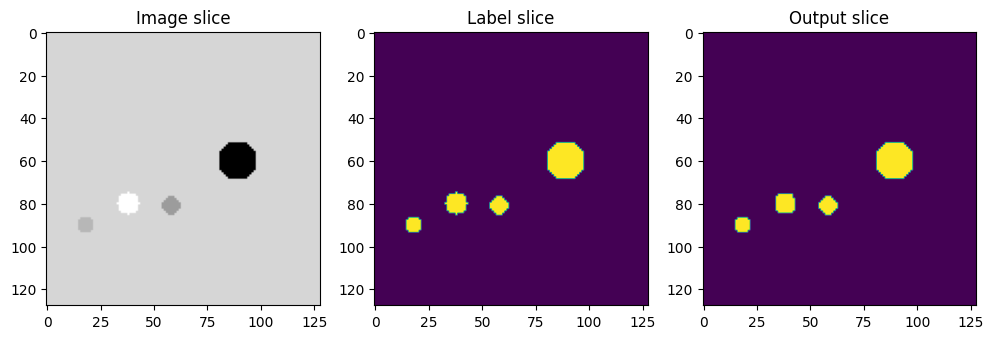

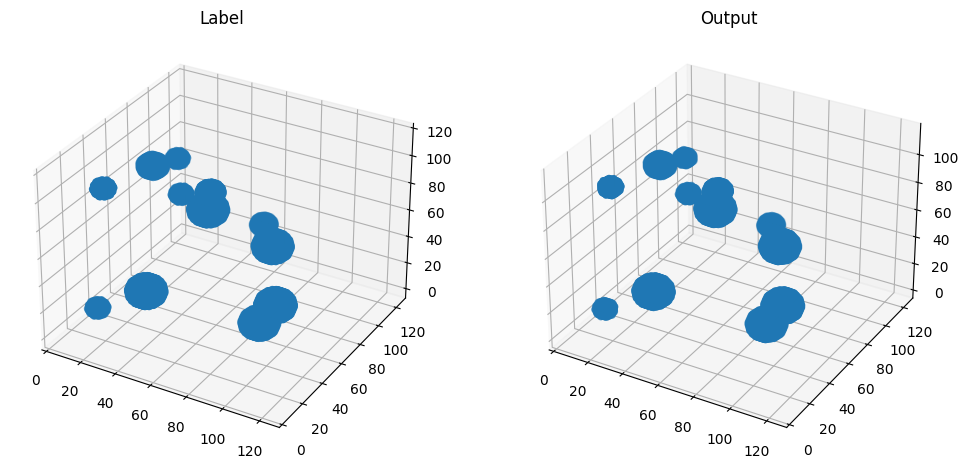



Noise = 1

----------
epoch 1/25
Loss: 0.8904 
Train dice: 0.4372
Test dice: 0.6885
Time: 22.5460
----------
epoch 2/25
Loss: 0.8163 
Train dice: 0.7414
Test dice: 0.8151
Time: 19.9448
----------
epoch 3/25
Loss: 0.7320 
Train dice: 0.8185
Test dice: 0.8983
Time: 21.2142
----------
epoch 4/25
Loss: 0.5919 
Train dice: 0.8979
Test dice: 0.9259
Time: 19.8517
----------
epoch 5/25
Loss: 0.4145 
Train dice: 0.9311
Test dice: 0.9485
Time: 20.6696
----------
epoch 6/25
Loss: 0.2606 
Train dice: 0.9445
Test dice: 0.9610
Time: 19.9082
----------
epoch 7/25
Loss: 0.1690 
Train dice: 0.9511
Test dice: 0.9633
Time: 20.2669
----------
epoch 8/25
Loss: 0.1179 
Train dice: 0.9580
Test dice: 0.9611
Time: 20.5701
----------
epoch 9/25
Loss: 0.0905 
Train dice: 0.9617
Test dice: 0.9696
Time: 19.5806
----------
epoch 10/25
Loss: 0.0738 
Train dice: 0.9651
Test dice: 0.9705
Time: 20.5048
----------
epoch 11/25
Loss: 0.0636 
Train dice: 0.9665
Test dice: 0.9737
Time: 19.6312
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

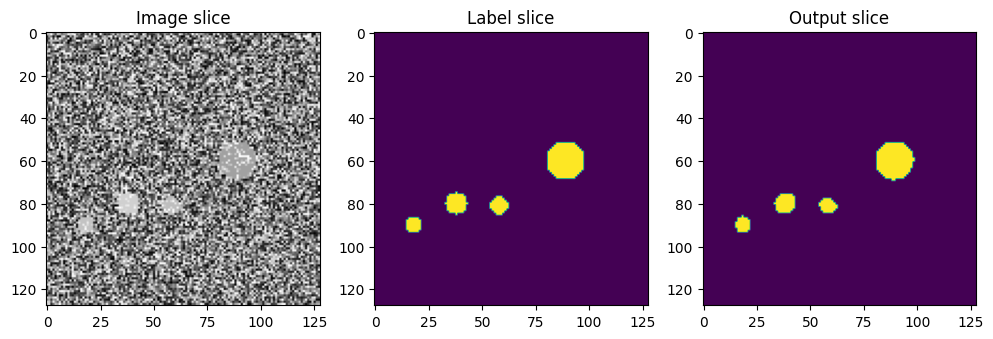

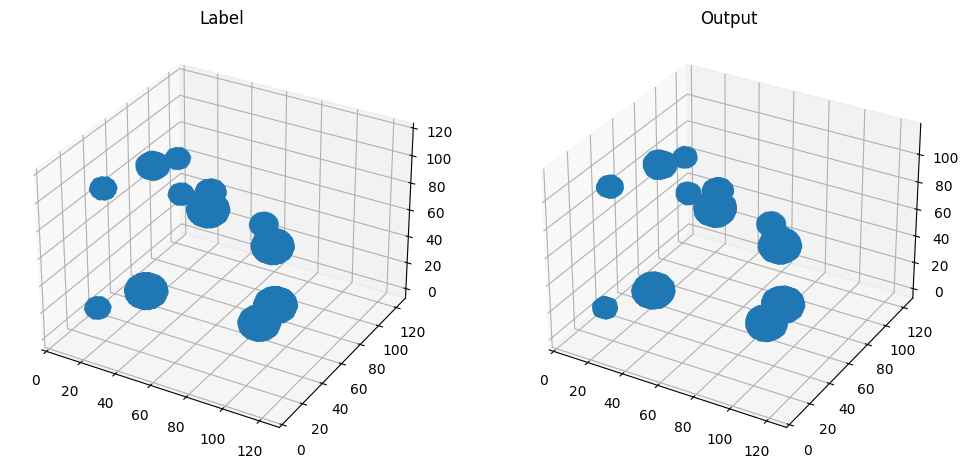



Noise = 2

----------
epoch 1/25
Loss: 0.8554 
Train dice: 0.4487
Test dice: 0.6726
Time: 21.0942
----------
epoch 2/25
Loss: 0.7338 
Train dice: 0.7579
Test dice: 0.8559
Time: 21.0062
----------
epoch 3/25
Loss: 0.5926 
Train dice: 0.8377
Test dice: 0.8763
Time: 19.9439
----------
epoch 4/25
Loss: 0.4134 
Train dice: 0.8902
Test dice: 0.8983
Time: 21.0178
----------
epoch 5/25
Loss: 0.2631 
Train dice: 0.9117
Test dice: 0.9135
Time: 19.8834
----------
epoch 6/25
Loss: 0.1781 
Train dice: 0.9140
Test dice: 0.9177
Time: 20.6804
----------
epoch 7/25
Loss: 0.1375 
Train dice: 0.9163
Test dice: 0.9102
Time: 20.2801
----------
epoch 8/25
Loss: 0.1083 
Train dice: 0.9257
Test dice: 0.9351
Time: 19.9828
----------
epoch 9/25
Loss: 0.0938 
Train dice: 0.9276
Test dice: 0.9336
Time: 20.5224
----------
epoch 10/25
Loss: 0.0827 
Train dice: 0.9317
Test dice: 0.9417
Time: 19.4921
----------
epoch 11/25
Loss: 0.0714 
Train dice: 0.9401
Test dice: 0.9466
Time: 21.0915
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

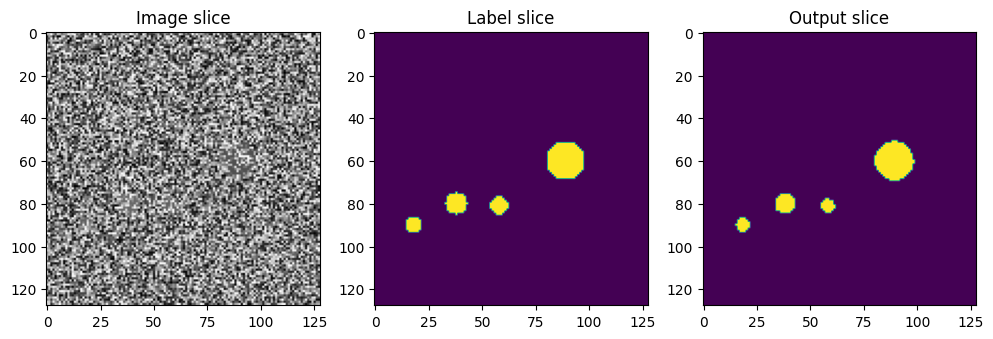

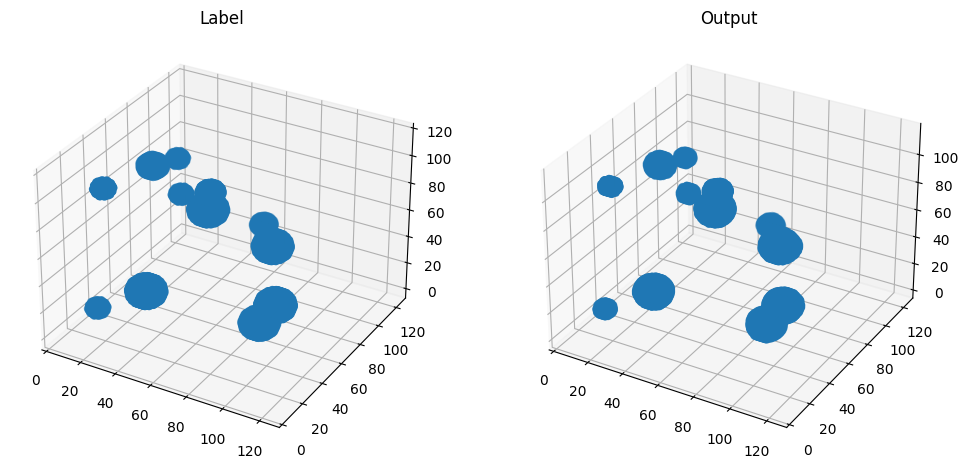



Noise = 3

----------
epoch 1/25
Loss: 0.8953 
Train dice: 0.2711
Test dice: 0.4626
Time: 22.9555
----------
epoch 2/25
Loss: 0.7566 
Train dice: 0.6467
Test dice: 0.7575
Time: 19.8426
----------
epoch 3/25
Loss: 0.6091 
Train dice: 0.7621
Test dice: 0.8323
Time: 20.8663
----------
epoch 4/25
Loss: 0.4274 
Train dice: 0.8309
Test dice: 0.8559
Time: 19.9711
----------
epoch 5/25
Loss: 0.2922 
Train dice: 0.8429
Test dice: 0.8569
Time: 20.4561
----------
epoch 6/25
Loss: 0.2258 
Train dice: 0.8388
Test dice: 0.8571
Time: 19.9698
----------
epoch 7/25
Loss: 0.1749 
Train dice: 0.8592
Test dice: 0.8530
Time: 20.4121
----------
epoch 8/25
Loss: 0.1551 
Train dice: 0.8620
Test dice: 0.8829
Time: 20.1118
----------
epoch 9/25
Loss: 0.1410 
Train dice: 0.8665
Test dice: 0.8854
Time: 20.1225
----------
epoch 10/25
Loss: 0.1160 
Train dice: 0.8873
Test dice: 0.8877
Time: 20.7422
----------
epoch 11/25
Loss: 0.1078 
Train dice: 0.8919
Test dice: 0.9030
Time: 19.6857
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

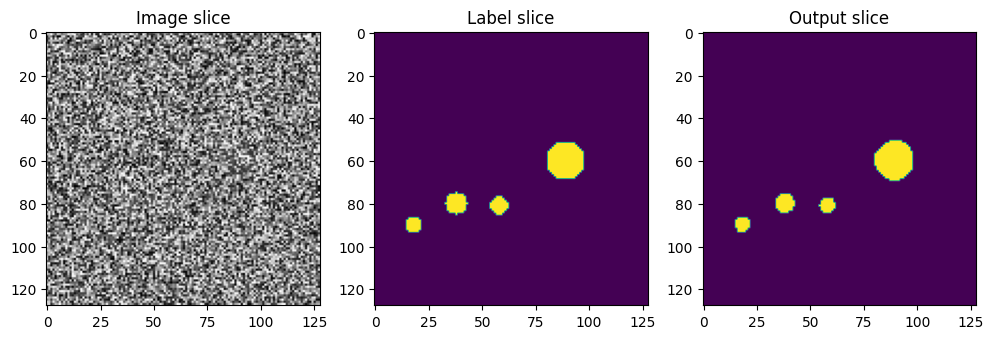

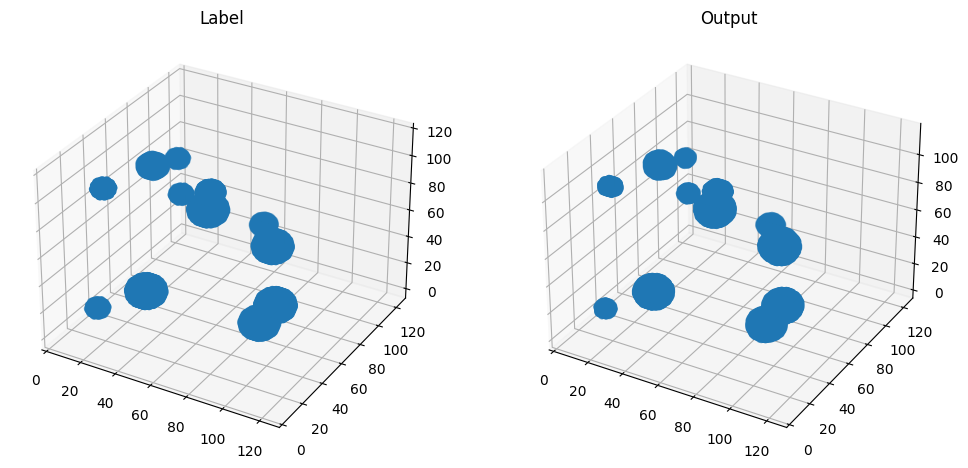



Noise = 4

----------
epoch 1/25
Loss: 0.9090 
Train dice: 0.1698
Test dice: 0.5243
Time: 22.0313
----------
epoch 2/25
Loss: 0.7884 
Train dice: 0.5246
Test dice: 0.6827
Time: 20.7585
----------
epoch 3/25
Loss: 0.6477 
Train dice: 0.6537
Test dice: 0.7485
Time: 21.6099
----------
epoch 4/25
Loss: 0.4941 
Train dice: 0.7076
Test dice: 0.7445
Time: 20.8805
----------
epoch 5/25
Loss: 0.3643 
Train dice: 0.7412
Test dice: 0.7718
Time: 21.6576
----------
epoch 6/25
Loss: 0.3014 
Train dice: 0.7390
Test dice: 0.7779
Time: 20.4504
----------
epoch 7/25
Loss: 0.2490 
Train dice: 0.7676
Test dice: 0.8069
Time: 21.1892
----------
epoch 8/25
Loss: 0.2018 
Train dice: 0.8015
Test dice: 0.8557
Time: 19.5791
----------
epoch 9/25
Loss: 0.1817 
Train dice: 0.8137
Test dice: 0.8617
Time: 22.0545
----------
epoch 10/25
Loss: 0.1349 
Train dice: 0.8632
Test dice: 0.8739
Time: 20.1614
----------
epoch 11/25
Loss: 0.1196 
Train dice: 0.8735
Test dice: 0.8953
Time: 20.9123
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

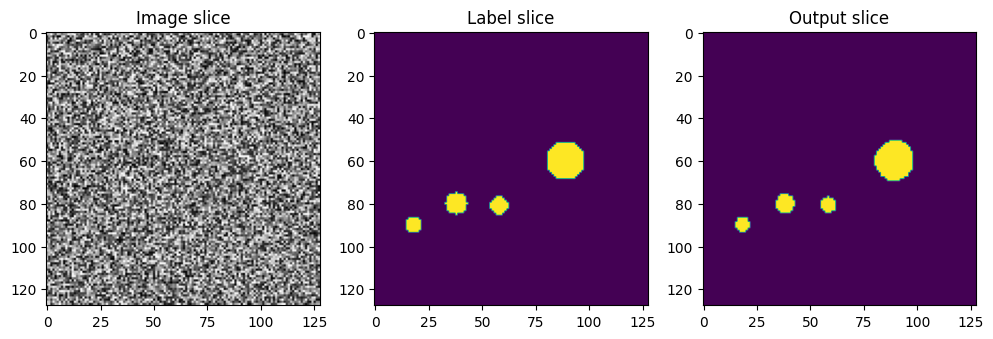

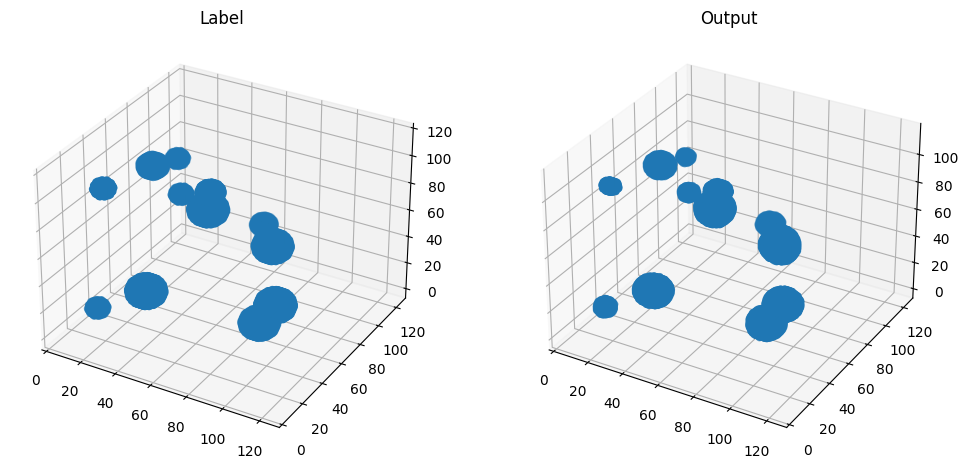



Noise = 5

----------
epoch 1/25
Loss: 0.9365 
Train dice: 0.0527
Test dice: 0.2440
Time: 21.5017
----------
epoch 2/25
Loss: 0.8409 
Train dice: 0.3654
Test dice: 0.5083
Time: 20.7330
----------
epoch 3/25
Loss: 0.7182 
Train dice: 0.4972
Test dice: 0.5728
Time: 19.3678
----------
epoch 4/25
Loss: 0.5673 
Train dice: 0.5708
Test dice: 0.6011
Time: 20.6015
----------
epoch 5/25
Loss: 0.4543 
Train dice: 0.6088
Test dice: 0.6172
Time: 19.2375
----------
epoch 6/25
Loss: 0.3938 
Train dice: 0.6248
Test dice: 0.6490
Time: 20.6907
----------
epoch 7/25
Loss: 0.4008 
Train dice: 0.5889
Test dice: 0.6488
Time: 19.3227
----------
epoch 8/25
Loss: 0.3217 
Train dice: 0.6627
Test dice: 0.7577
Time: 20.5762
----------
epoch 9/25
Loss: 0.2603 
Train dice: 0.7234
Test dice: 0.7451
Time: 19.1210
----------
epoch 10/25
Loss: 0.2342 
Train dice: 0.7443
Test dice: 0.8212
Time: 20.5602
----------
epoch 11/25
Loss: 0.1747 
Train dice: 0.8061
Test dice: 0.8265
Time: 19.0695
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

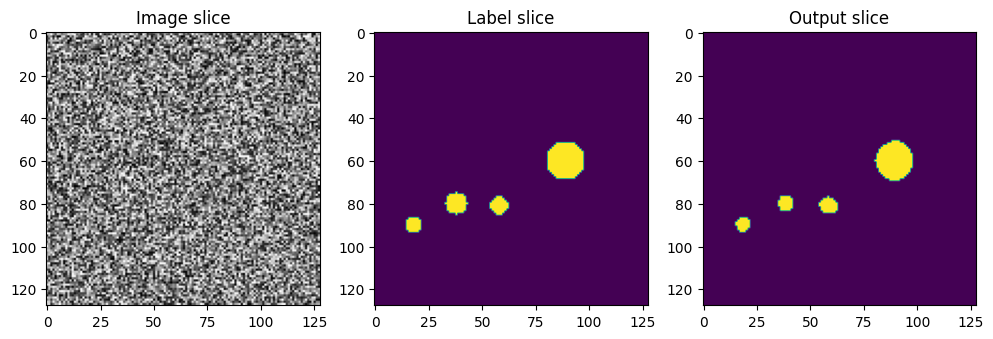

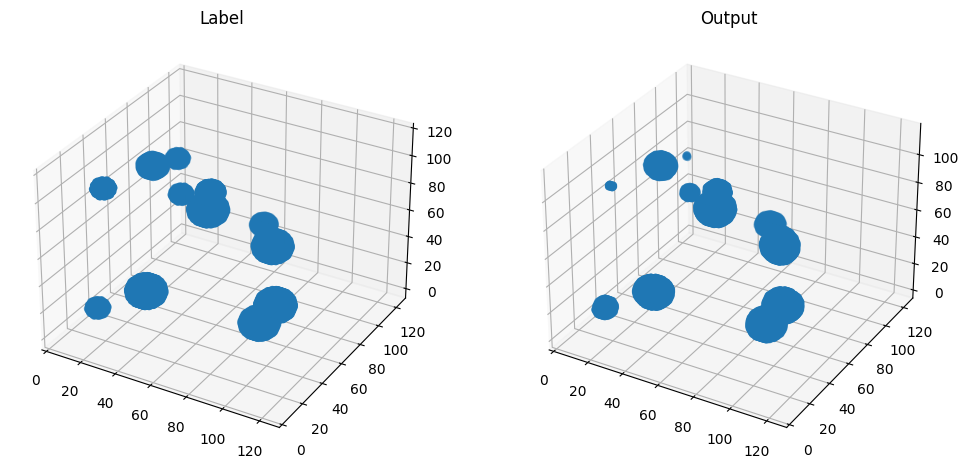



Noise = 6

----------
epoch 1/25
Loss: 0.9341 
Train dice: 0.0716
Test dice: 0.2259
Time: 21.8522
----------
epoch 2/25
Loss: 0.8559 
Train dice: 0.2867
Test dice: 0.4220
Time: 20.4955
----------
epoch 3/25
Loss: 0.7620 
Train dice: 0.3804
Test dice: 0.4395
Time: 20.5726
----------
epoch 4/25
Loss: 0.6409 
Train dice: 0.4565
Test dice: 0.4578
Time: 19.8936
----------
epoch 5/25
Loss: 0.5582 
Train dice: 0.4694
Test dice: 0.4603
Time: 21.2065
----------
epoch 6/25
Loss: 0.5077 
Train dice: 0.4855
Test dice: 0.5122
Time: 19.6592
----------
epoch 7/25
Loss: 0.4588 
Train dice: 0.5192
Test dice: 0.5758
Time: 21.4673
----------
epoch 8/25
Loss: 0.4144 
Train dice: 0.5599
Test dice: 0.6560
Time: 19.8290
----------
epoch 9/25
Loss: 0.3345 
Train dice: 0.6370
Test dice: 0.7515
Time: 21.2457
----------
epoch 10/25
Loss: 0.2662 
Train dice: 0.7061
Test dice: 0.7406
Time: 20.5574
----------
epoch 11/25
Loss: 0.2157 
Train dice: 0.7590
Test dice: 0.8257
Time: 21.6158
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

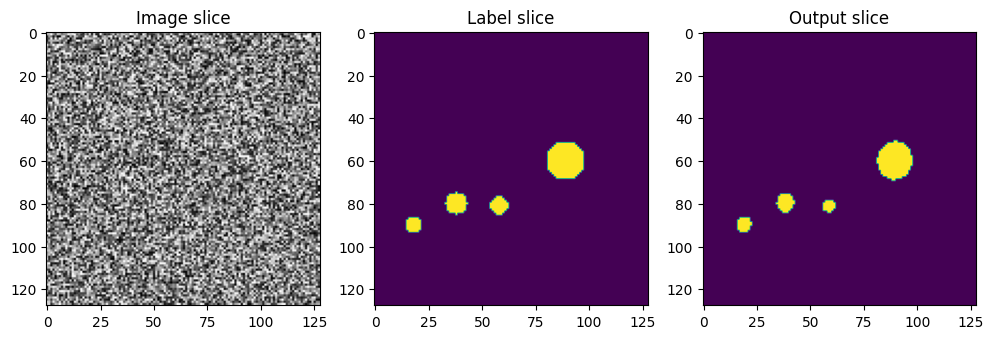

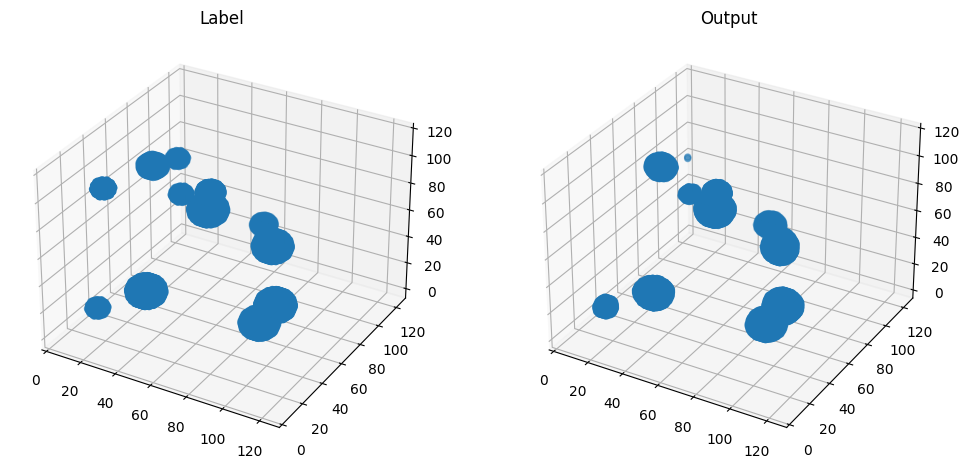



Noise = 7

----------
epoch 1/25
Loss: 0.9402 
Train dice: 0.0195
Test dice: 0.1582
Time: 22.7805
----------
epoch 2/25
Loss: 0.8902 
Train dice: 0.2016
Test dice: 0.2518
Time: 19.6041
----------
epoch 3/25
Loss: 0.8184 
Train dice: 0.2711
Test dice: 0.3160
Time: 21.3268
----------
epoch 4/25
Loss: 0.7136 
Train dice: 0.3438
Test dice: 0.3207
Time: 19.6641
----------
epoch 5/25
Loss: 0.6551 
Train dice: 0.3514
Test dice: 0.3349
Time: 21.1393
----------
epoch 6/25
Loss: 0.6152 
Train dice: 0.3592
Test dice: 0.3526
Time: 19.9546
----------
epoch 7/25
Loss: 0.6058 
Train dice: 0.3545
Test dice: 0.3590
Time: 21.3242
----------
epoch 8/25
Loss: 0.5713 
Train dice: 0.3882
Test dice: 0.3622
Time: 19.9584
----------
epoch 9/25
Loss: 0.5706 
Train dice: 0.3857
Test dice: 0.3931
Time: 21.5013
----------
epoch 10/25
Loss: 0.5475 
Train dice: 0.4074
Test dice: 0.4200
Time: 20.5757
----------
epoch 11/25
Loss: 0.5211 
Train dice: 0.4336
Test dice: 0.4274
Time: 21.6456
----------
epoch 12/25
Loss:

<Figure size 640x480 with 0 Axes>

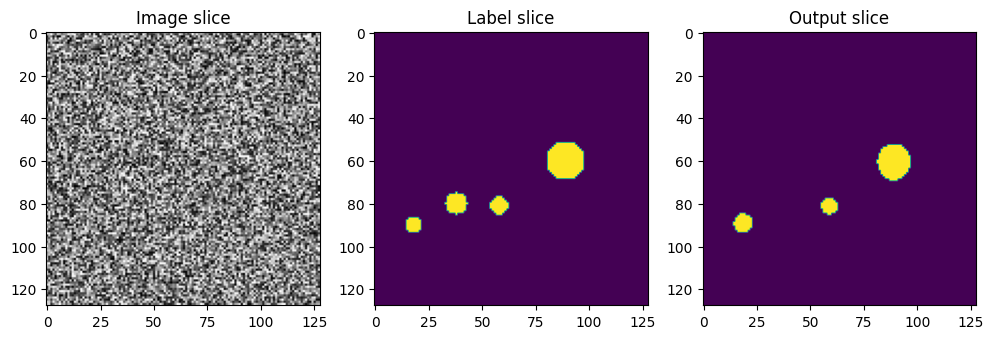

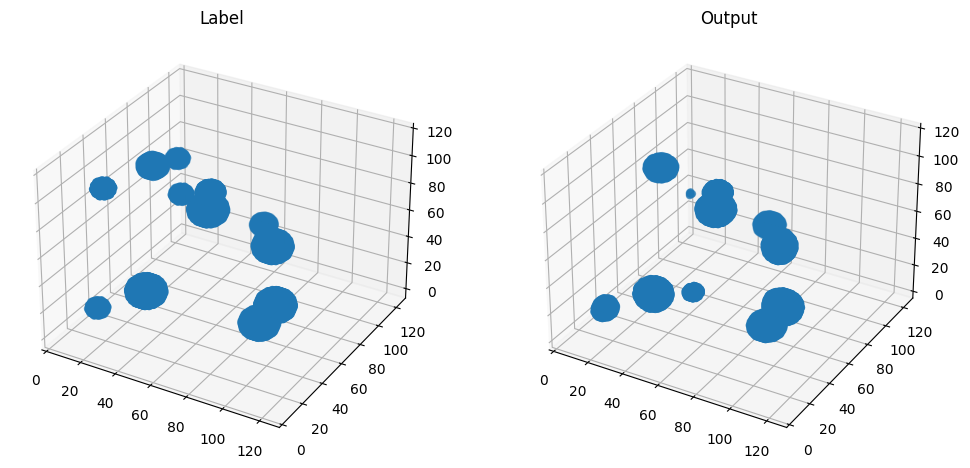

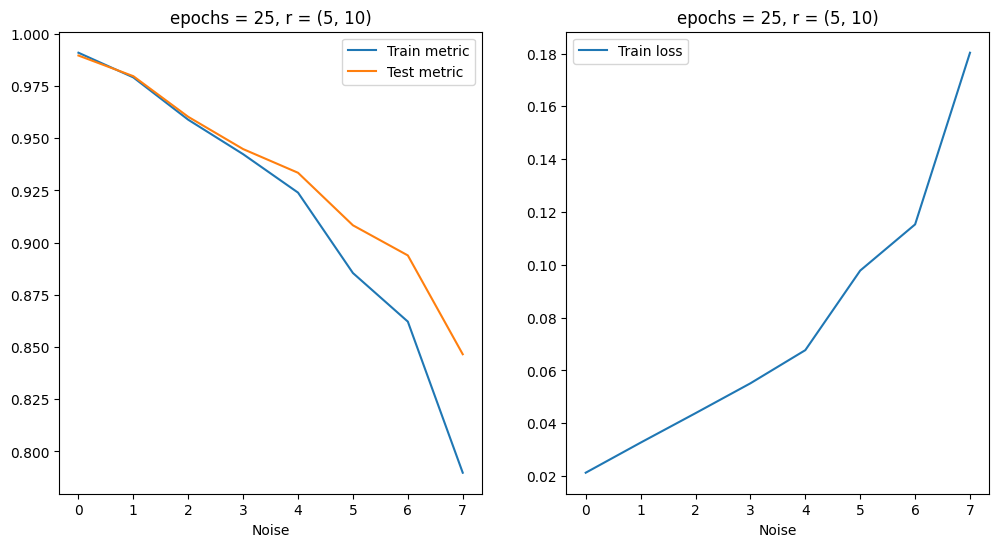

In [12]:
n_train = 30
n_test = 20

noise_vec = [0, 1, 2, 3, 4, 5, 6, 7]
r_min = 5
r_max = 10

max_epochs = 25

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for noise in noise_vec:
  print()
  print(f"Noise = {noise}")
  print()

  train_files, val_files = create_image_3d(n_train, n_test, noise, r_min, r_max)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

plot_noise(noise_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, max_epochs)